In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'
import seaborn as sns

sns.set_theme(style="darkgrid")
%load_ext lab_black

# 2 Exercises

## 2.1 Univariate regression on analytical functions

### 2.1.1 Generate the dataset

First of all let's generate the data

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
def gen_data(f):
    tr = 20
    n_samples = 100
    X = np.linspace(-tr, tr, n_samples)
    y = f(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, random_state=42, shuffle=True
    )
    y_test = y_test[X_test.argsort()]
    X_test.sort()
    return X_train, X_test, y_train, y_test

Using our three defined functions

In [4]:
def f1(x):
    return x * np.sin(x) + 2 * x


def f2(x):
    return 10 * np.sin(x) + x ** 2


def f3(x):
    return np.sign(x) * (x ** 2 + 300) + 20 * np.sin(x)

### 2.1.2 Plotting the data

Then plot them

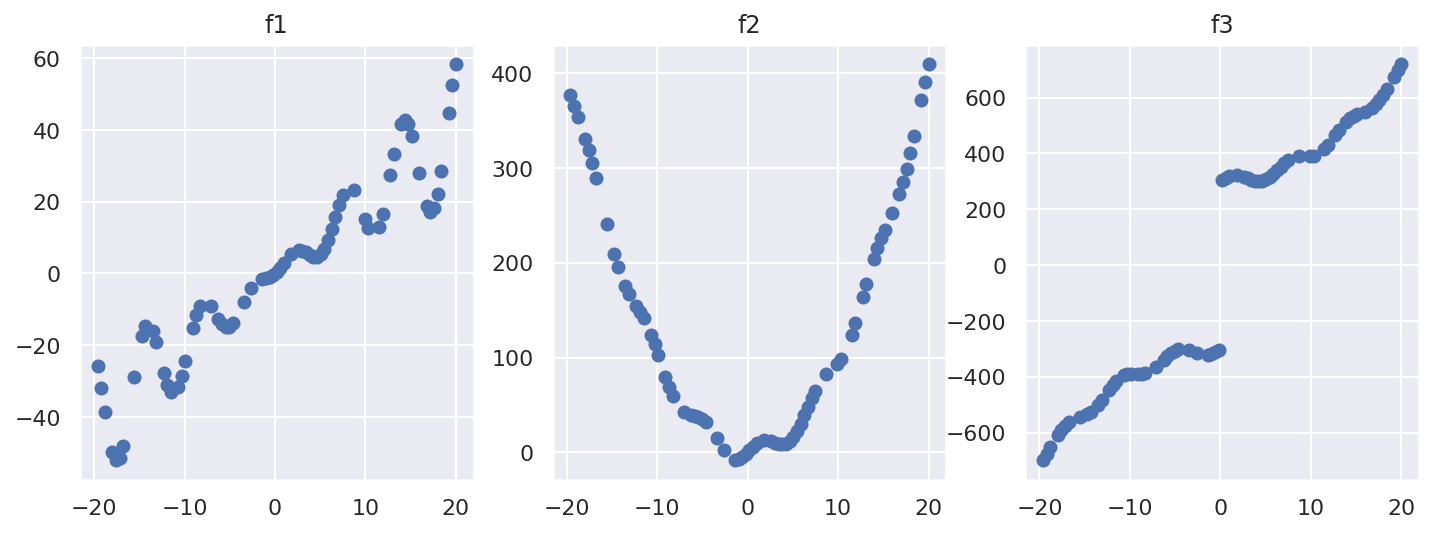

In [5]:
_, axes = plt.subplots(1, 3, figsize=(12, 4))
for f, ax in zip([f1, f2, f3], axes):
    x, _, y, _ = gen_data(f)
    ax.scatter(x, y)
    ax.set_title(f.__name__)

### 2.1.3 Train regressors, evaluate, and feature engineering

#### 2.1.3.1 OLS

In [6]:
from sklearn.metrics import r2_score, mean_squared_error


def evaluate(reg):
    _, axes = plt.subplots(1, 3, figsize=(12, 4))
    for f, ax in zip([f1, f2, f3], axes):
        X_train, X_test, y_train, y_test = gen_data(f)
        X_train = X_train.reshape(-1, 1)
        X_test = X_test.reshape(-1, 1)

        reg.fit(X_train, y_train)
        y_test_pred = reg.predict(X_test)

        ax.scatter(X_train, y_train)
        ax.scatter(X_test, y_test_pred)
        ax.legend(["Train", "Pred"])

        ax.set_title(f"R2: {r2_score(y_test, y_test_pred):.3f}")

First of all apply OLS to all functions, regardless of its shape

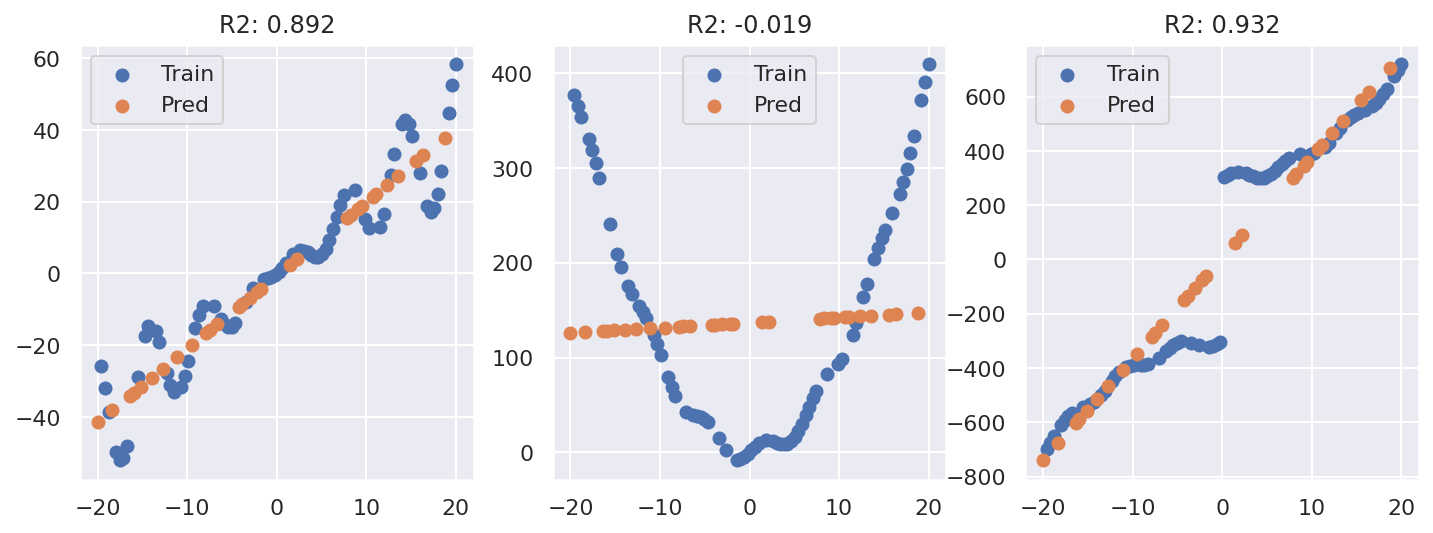

In [7]:
from sklearn.linear_model import LinearRegression

evaluate(LinearRegression(fit_intercept=True))

#### 2.1.3.2 Polynomial regression

Function 2 looks very much like a parabula, let's try using a polynomial regression

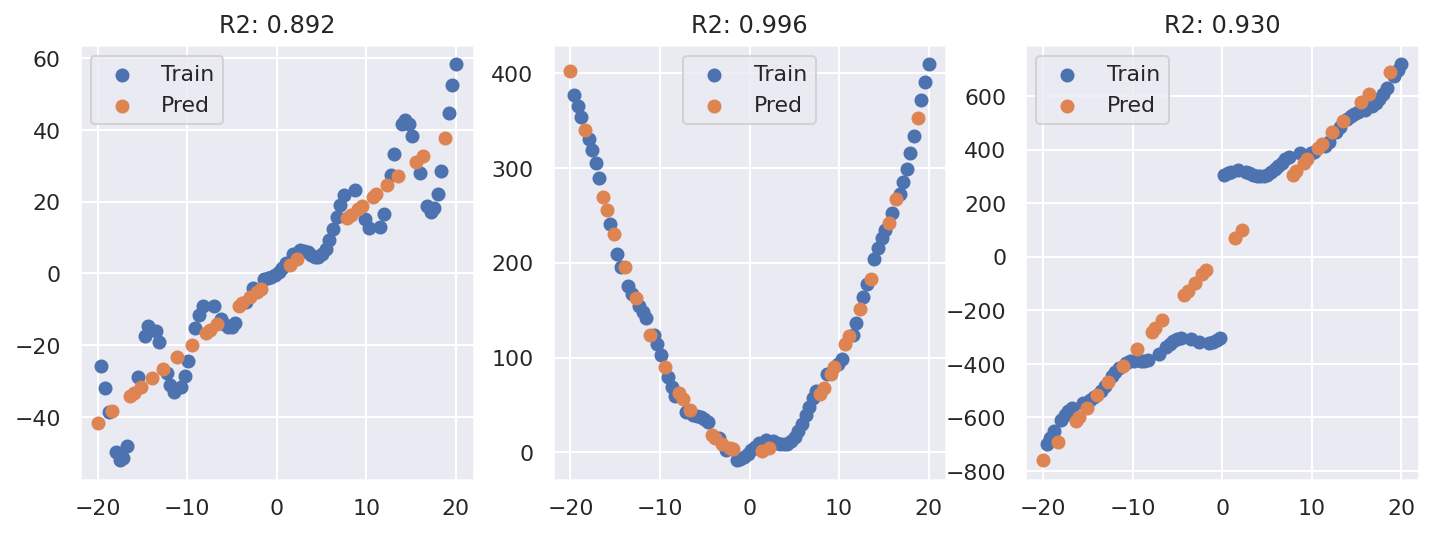

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

evaluate(
    Pipeline(
        [
            ("make_2nd_order_terms", PolynomialFeatures(degree=2)),
            ("linear_regression", LinearRegression(fit_intercept=True)),
        ]
    )
)

Much better

### 2.1.3.3 More complex models: (Random Forest, MLP, Gaussian Process)

Function 3 has discontinuities that require more advanced techniques

Random forests perform very well even with discontinuities

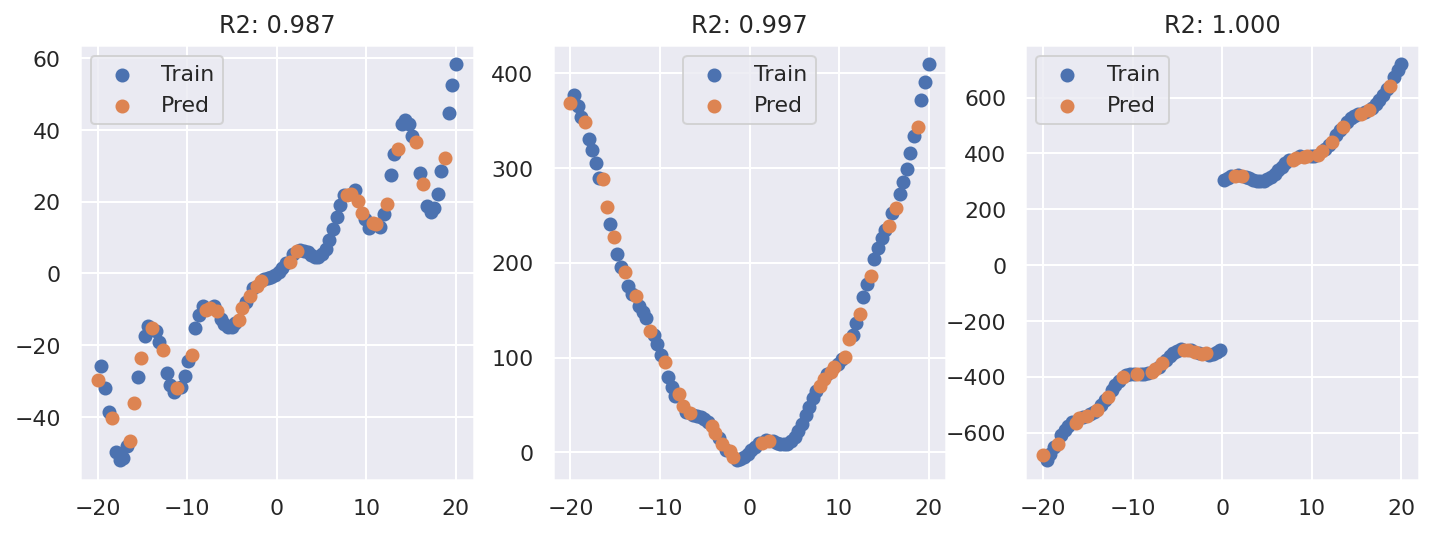

In [9]:
from sklearn.ensemble import RandomForestRegressor

evaluate(RandomForestRegressor())

After a bit of tuning, also neural networks can approximate well the functionss

/home/andrea/venv-environments/polito-dsl/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/andrea/venv-environments/polito-dsl/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


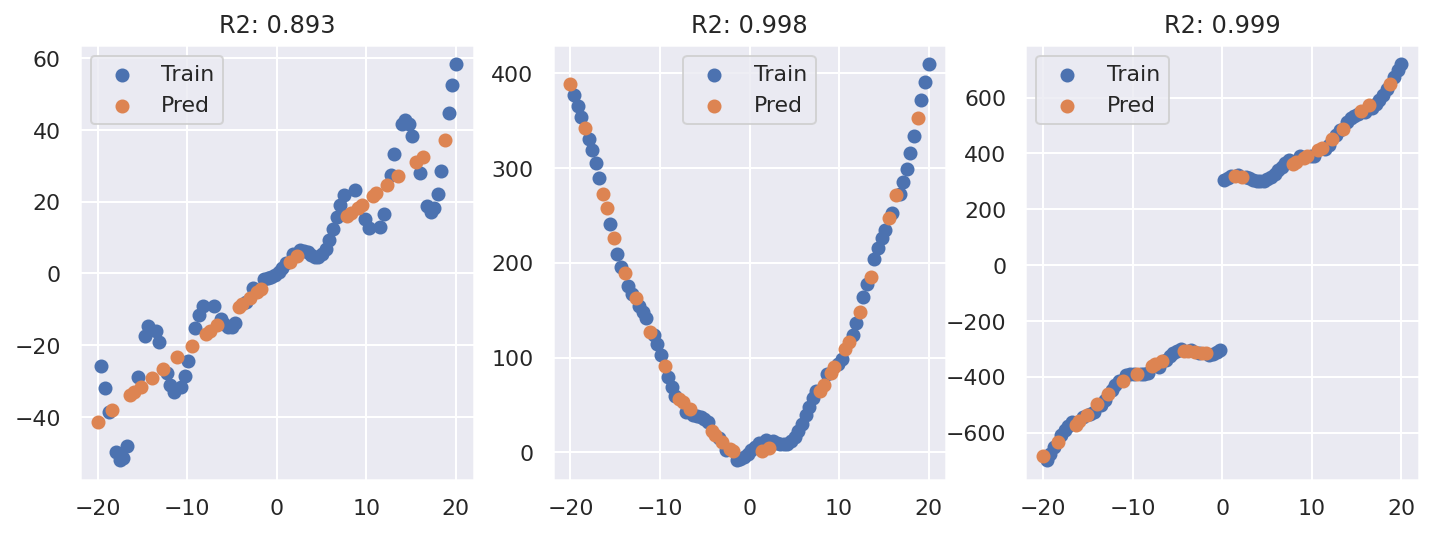

In [10]:
from sklearn.neural_network import MLPRegressor

evaluate(MLPRegressor(hidden_layer_sizes=(20, 10), max_iter=10_000))

Gaussian process regression works very well for $f_1$ and $f_2$, in $f_3$ the big jump makes for a very high-variance region thus the samples are very far from the actual function.

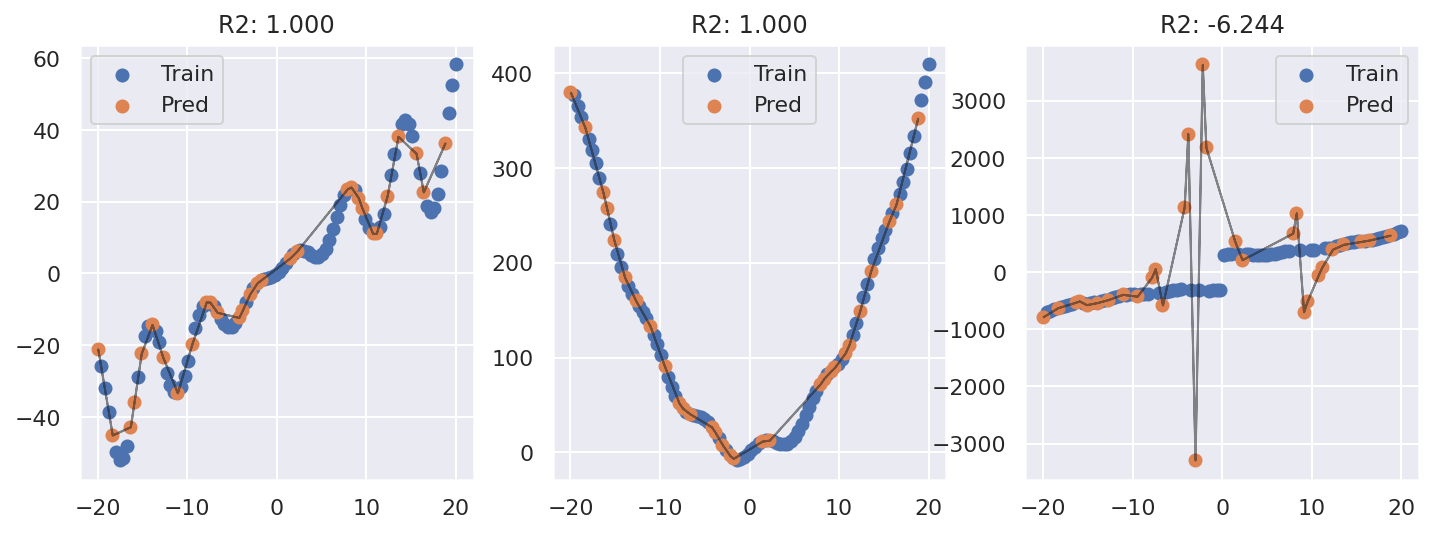

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor


def evaluate_gp():
    _, axes = plt.subplots(1, 3, figsize=(12, 4))
    for f, ax in zip([f1, f2, f3], axes):
        X_train, X_test, y_train, y_test = gen_data(f)
        X_train = X_train.reshape(-1, 1)
        X_test = X_test.reshape(-1, 1)

        reg = GaussianProcessRegressor()
        reg.fit(X_train, y_train)
        y_test_pred_mean, y_test_pred_cov = reg.predict(X_test, return_cov=True)

        ax.scatter(X_train, y_train)
        ax.scatter(X_test, y_test_pred_mean)
        ax.fill_between(
            X_test.reshape(-1),
            y_test_pred_mean - np.sqrt(np.diag(y_test_pred_cov)),
            y_test_pred_mean + np.sqrt(np.diag(y_test_pred_cov)),
            alpha=0.5,
            color="k",
        )
        ax.legend(["Train", "Pred"])

        ax.set_title(f"R2: {r2_score(y_test, y_test_pred_mean):.3f}")


evaluate_gp()

### 2.1.6 Noise robustness

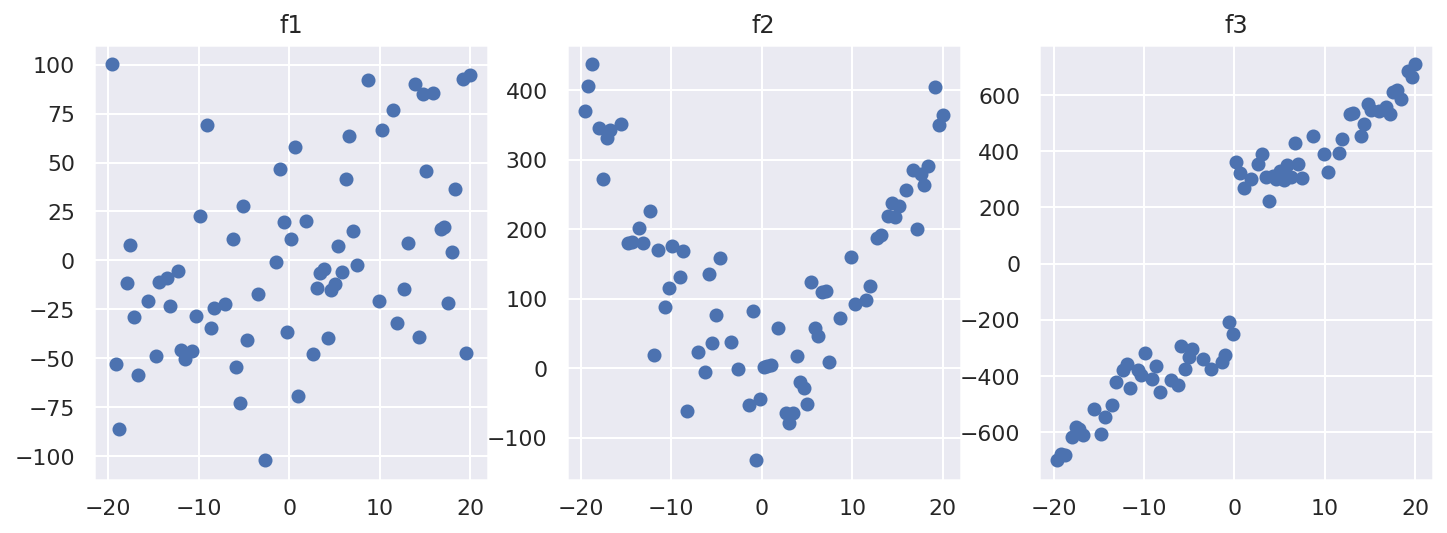

In [12]:
def gen_noisy_data(f):
    tr = 20
    n_samples = 100
    X = np.linspace(-tr, tr, n_samples)
    y = f(X)
    y = y + np.random.normal(0, 50, size=y.size)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, random_state=42, shuffle=True
    )
    y_test = y_test[X_test.argsort()]
    X_test.sort()
    return X_train, X_test, y_train, y_test


def evaluate_noisy(reg):
    _, axes = plt.subplots(1, 3, figsize=(12, 4))
    for f, ax in zip([f1, f2, f3], axes):
        X_train, X_test, y_train, y_test = gen_noisy_data(f)
        X_train = X_train.reshape(-1, 1)
        X_test = X_test.reshape(-1, 1)

        reg.fit(X_train, y_train)
        y_test_pred = reg.predict(X_test)

        ax.scatter(X_train, y_train)
        ax.scatter(X_test, y_test_pred)
        ax.legend(["Train", "Pred"])

        ax.set_title(f"R2: {r2_score(y_test, y_test_pred):.3f}")


_, axes = plt.subplots(1, 3, figsize=(12, 4))
for f, ax in zip([f1, f2, f3], axes):
    x, _, y, _ = gen_noisy_data(f)
    ax.scatter(x, y)
    ax.set_title(f.__name__)

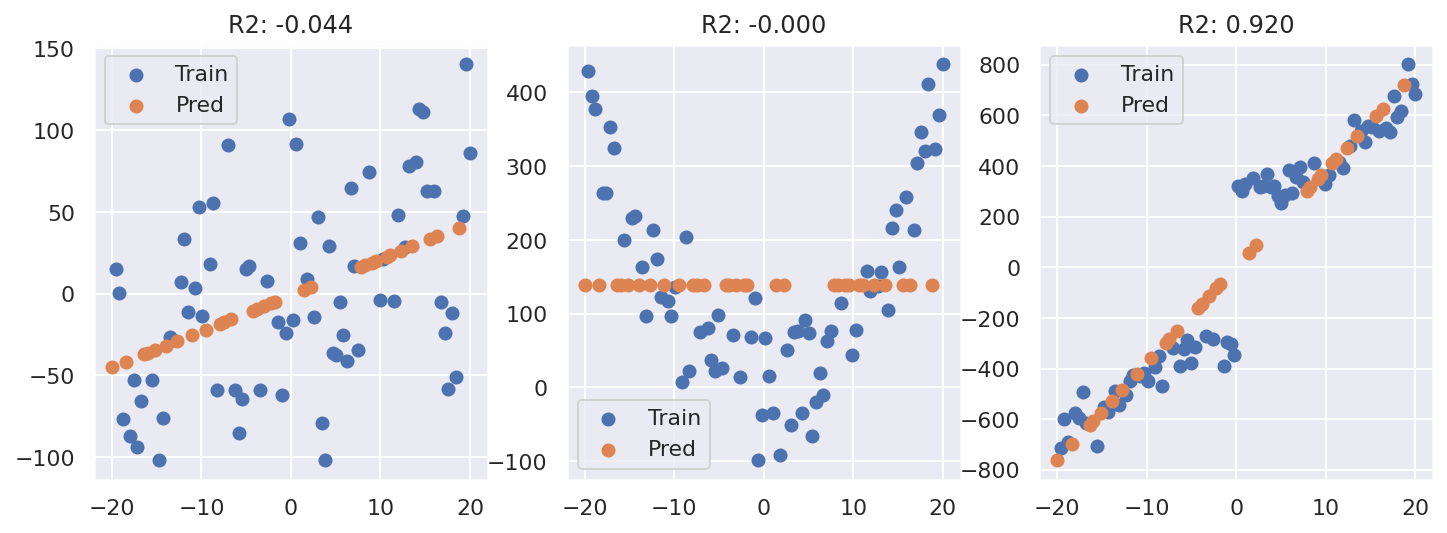

In [13]:
from sklearn.linear_model import LinearRegression

evaluate_noisy(LinearRegression(fit_intercept=True))

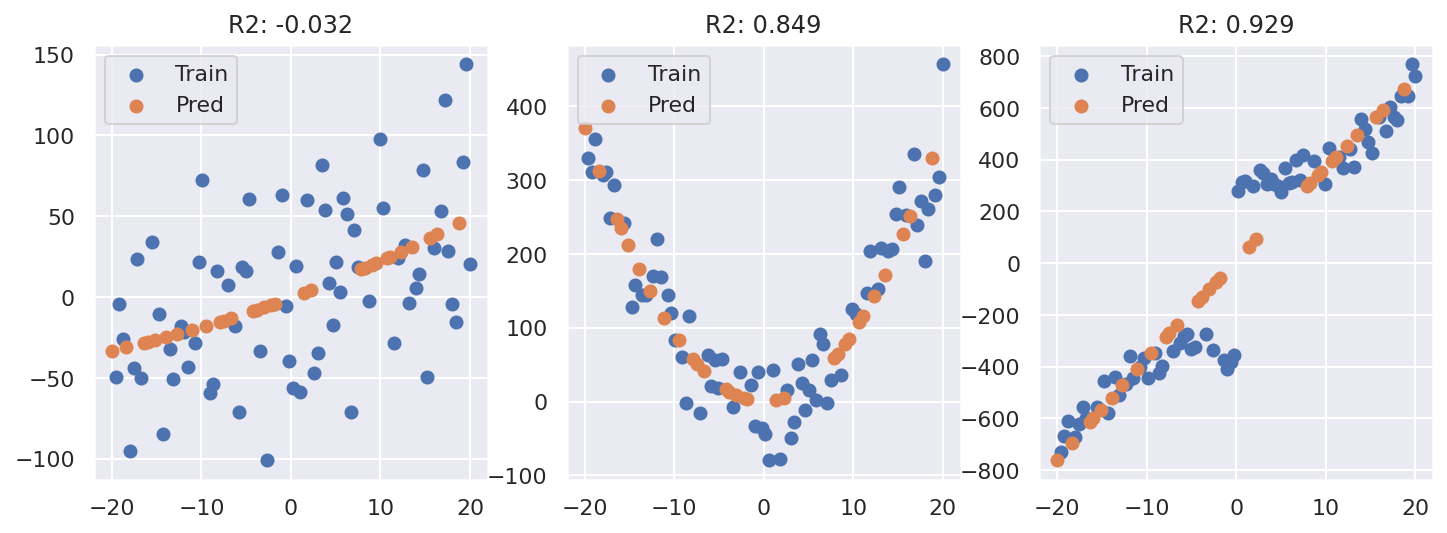

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

evaluate_noisy(
    Pipeline(
        [
            ("make_2nd_order_terms", PolynomialFeatures(degree=2)),
            ("linear_regression", LinearRegression(fit_intercept=True)),
        ]
    )
)

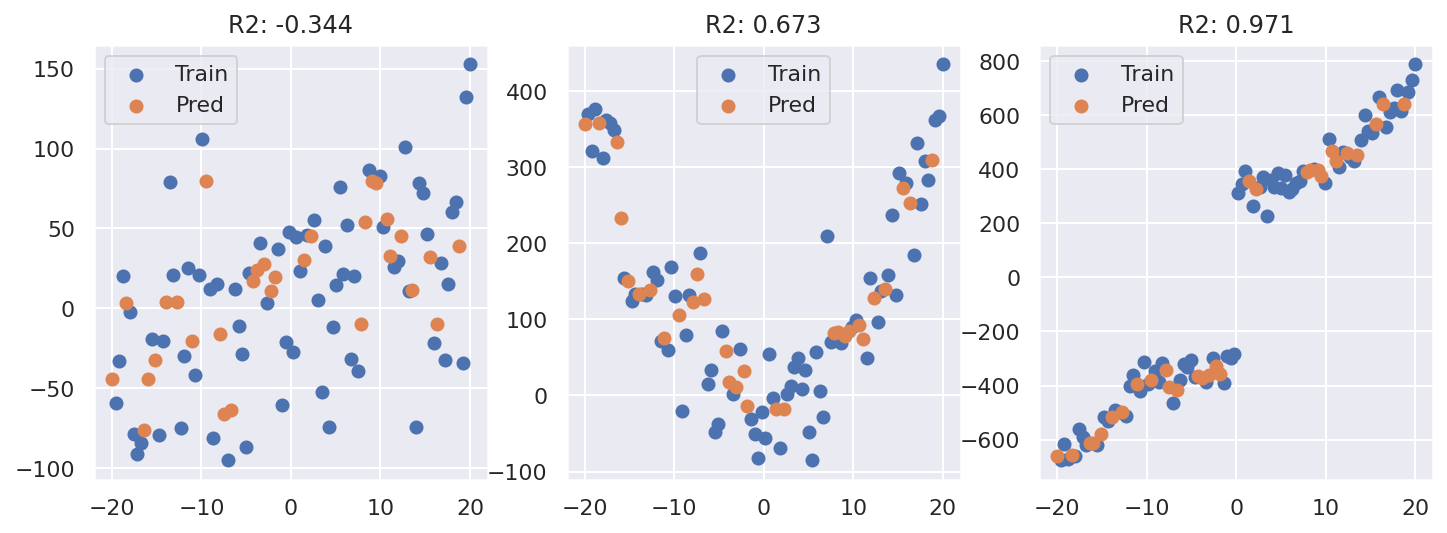

In [15]:
from sklearn.ensemble import RandomForestRegressor

evaluate_noisy(RandomForestRegressor())

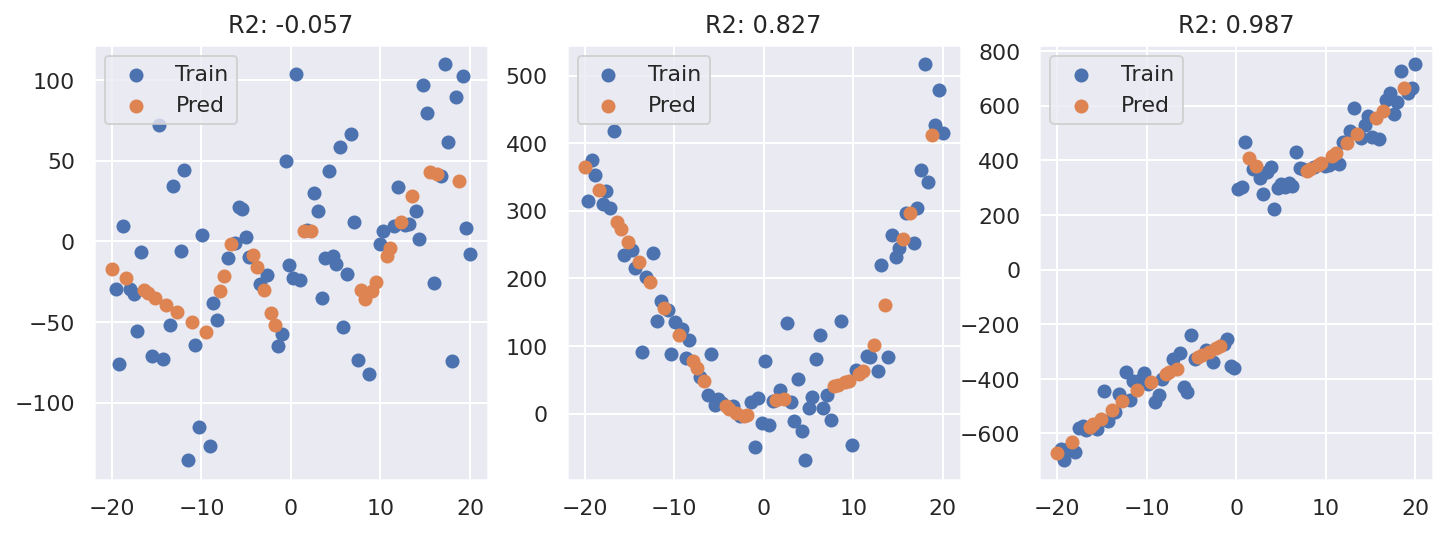

In [16]:
from sklearn.neural_network import MLPRegressor

evaluate_noisy(MLPRegressor(hidden_layer_sizes=(20, 10), max_iter=10_000))

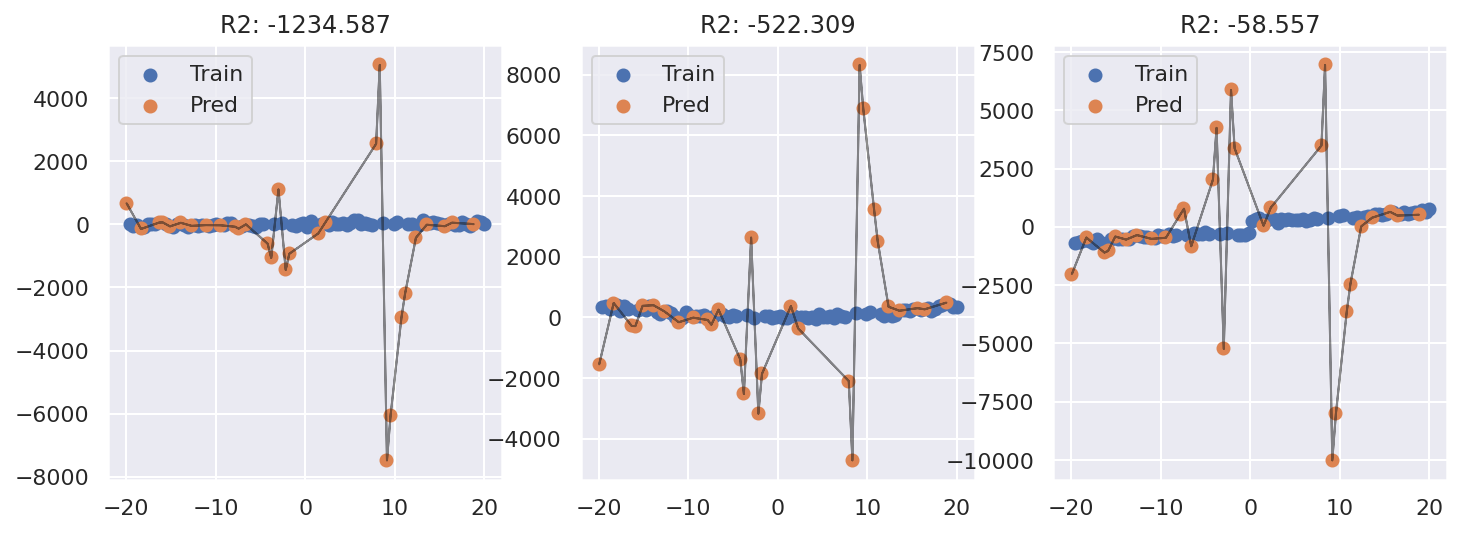

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor


def evaluate_noisy_gp():
    _, axes = plt.subplots(1, 3, figsize=(12, 4))
    for f, ax in zip([f1, f2, f3], axes):
        X_train, X_test, y_train, y_test = gen_noisy_data(f)
        X_train = X_train.reshape(-1, 1)
        X_test = X_test.reshape(-1, 1)

        reg = GaussianProcessRegressor()
        reg.fit(X_train, y_train)
        y_test_pred_mean, y_test_pred_cov = reg.predict(X_test, return_cov=True)

        ax.scatter(X_train, y_train)
        ax.scatter(X_test, y_test_pred_mean)
        ax.fill_between(
            X_test.reshape(-1),
            y_test_pred_mean - np.sqrt(np.diag(y_test_pred_cov)),
            y_test_pred_mean + np.sqrt(np.diag(y_test_pred_cov)),
            alpha=0.5,
            color="k",
        )
        ax.legend(["Train", "Pred"])

        ax.set_title(f"R2: {r2_score(y_test, y_test_pred_mean):.3f}")


evaluate_noisy_gp()

## 2.2 Multivariate regression on synthetic data

### 2.2.1 Generate synthetic dataset

In [18]:
from sklearn.datasets import make_regression

In [31]:
def evaluate_multivariate(reg):
    X, y = make_regression(n_samples=2_000, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, random_state=42, shuffle=True
    )

    reg.fit(X_train, y_train)
    y_test_pred = reg.predict(X_test)

    print(
        f"R2: {r2_score(y_test, y_test_pred):.3f}, MSE: {mean_squared_error(y_test, y_test_pred):.3f}"
    )

### 2.2.2 Evaluate it on past pipelines

In [32]:
evaluate_multivariate(LinearRegression(fit_intercept=True))

R2: 1.000, MSE: 0.000


In [33]:
evaluate_multivariate(
    Pipeline(
        [
            ("make_2nd_order_terms", PolynomialFeatures(degree=2)),
            ("linear_regression", LinearRegression(fit_intercept=True)),
        ]
    )
)

R2: 0.277, MSE: 28944.170


In [34]:
evaluate_multivariate(RandomForestRegressor())

R2: 0.733, MSE: 10674.964


In [35]:
evaluate_multivariate(MLPRegressor(hidden_layer_sizes=(20, 10), max_iter=10_000))

R2: 0.985, MSE: 589.020


Non potete deludermi cosi' pero'

In [36]:
evaluate_multivariate(GaussianProcessRegressor())

R2: -0.002, MSE: 40144.532


### 2.2.3 Make it harder

More noise, more informative features

In [37]:
def evaluate_multivariate_noisy(reg):
    X, y = make_regression(n_samples=2_000, random_state=42, noise=50, n_informative=50)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, random_state=42, shuffle=True
    )

    reg.fit(X_train, y_train)
    y_test_pred = reg.predict(X_test)

    print(
        f"R2: {r2_score(y_test, y_test_pred):.3f}, MSE: {mean_squared_error(y_test, y_test_pred):.3f}"
    )

In [38]:
evaluate_multivariate_noisy(LinearRegression(fit_intercept=True))

R2: 0.988, MSE: 2674.671


In [39]:
evaluate_multivariate_noisy(
    Pipeline(
        [
            ("make_2nd_order_terms", PolynomialFeatures(degree=2)),
            ("linear_regression", LinearRegression(fit_intercept=True)),
        ]
    )
)

R2: 0.294, MSE: 156348.235


In [40]:
evaluate_multivariate_noisy(RandomForestRegressor())

R2: 0.356, MSE: 142461.333


Neural networks are __amazing__ at noise robustness

In [41]:
evaluate_multivariate_noisy(MLPRegressor(hidden_layer_sizes=(20, 10), max_iter=10_000))

R2: 0.964, MSE: 8008.329


In [42]:
evaluate_multivariate_noisy(GaussianProcessRegressor())

R2: -0.000, MSE: 221444.396


## 2.3 Temperature series forecasting

### 2.3.1 Importing data

The dataset contains ~119k readings from 159 weather stations all around the world between 1942 and 1945.

Notable fields are:

- `STA`: station id
- `Date`: date of recording
- `MaxTemp`: daily maximum temperatures in celsius
- `MinTemp`: daily maximum temperatures in celsius
- `MeanTemp`: daily mean temperatures in celsius

In [153]:
df = (
    pd.read_csv(
        "../datasets/SummaryofWeather.csv",
        usecols=["STA", "Date", "MaxTemp", "MinTemp", "MeanTemp"],
        parse_dates=["Date"],
    )
    .set_index(["STA", "Date"])
    .sort_index(level=[0, 1])
)
df

MaxTemp    MinTemp   MeanTemp
STA   Date                                       
10001 1942-07-01  25.555556  22.222222  23.888889
      1942-07-02  28.888889  21.666667  25.555556
      1942-07-03  26.111111  22.222222  24.444444
      1942-07-04  26.666667  22.222222  24.444444
      1942-07-05  26.666667  21.666667  24.444444
...                     ...        ...        ...
82506 1945-12-27  28.333333  18.333333  23.333333
      1945-12-28  29.444444  18.333333  23.888889
      1945-12-29  28.333333  18.333333  23.333333
      1945-12-30  28.333333  18.333333  23.333333
      1945-12-31  29.444444  17.222222  23.333333

[119040 rows x 3 columns]

Check that multi-index has been created correctly

In [154]:
df.index.levels[0]

Int64Index([10001, 10002, 10101, 10102, 10502, 10505, 10701, 10703, 10704,
            10705,
            ...
            81601, 81702, 82402, 82403, 82404, 82405, 82501, 82502, 82503,
            82506],
           dtype='int64', name='STA', length=159)

In [155]:
df.index.levels[1]

DatetimeIndex(['1940-01-01', '1940-01-02', '1940-01-03', '1940-01-04',
               '1940-01-05', '1940-01-06', '1940-01-07', '1940-01-08',
               '1940-01-09', '1940-01-10',
               ...
               '1945-12-22', '1945-12-23', '1945-12-24', '1945-12-25',
               '1945-12-26', '1945-12-27', '1945-12-28', '1945-12-29',
               '1945-12-30', '1945-12-31'],
              dtype='datetime64[ns]', name='Date', length=2192, freq=None)

### 2.3.2 Data sanity checks

The data makes sense, min of `MinTemp` is -38 which seems possible for North Pole while max of `MaxTemp` is 50 which seems possible for desertic areas.

In [156]:
df.describe()

,MaxTemp,MinTemp,MeanTemp
count,119040.000000,119040.000000,119040.000000
mean,27.045111,17.789511,22.411631
std,8.717817,8.334572,8.297982
min,-33.333333,-38.333333,-35.555556
25%,25.555556,15.000000,20.555556
50%,29.444444,21.111111,25.555556
75%,31.666667,23.333333,27.222222
max,50.000000,34.444444,40.000000


In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 119040 entries, (10001, Timestamp('1942-07-01 00:00:00')) to (82506, Timestamp('1945-12-31 00:00:00'))
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   MaxTemp   119040 non-null  float64
 1   MinTemp   119040 non-null  float64
 2   MeanTemp  119040 non-null  float64
dtypes: float64(3)
memory usage: 3.3 MB


Count how many weather stations we have, and how many measurements per weather station

In [159]:
df.groupby(level=0).count()["MaxTemp"].sort_values()

STA
33121      13
34101      31
43307      46
33123      47
42206      50
         ... 
10803    1750
22504    2118
22502    2154
10701    2185
22508    2192
Name: MaxTemp, Length: 159, dtype: int64

Most of measurement stations have a good amount of samples

Text(0.5, 1.0, 'Number of measurements from station distribution')

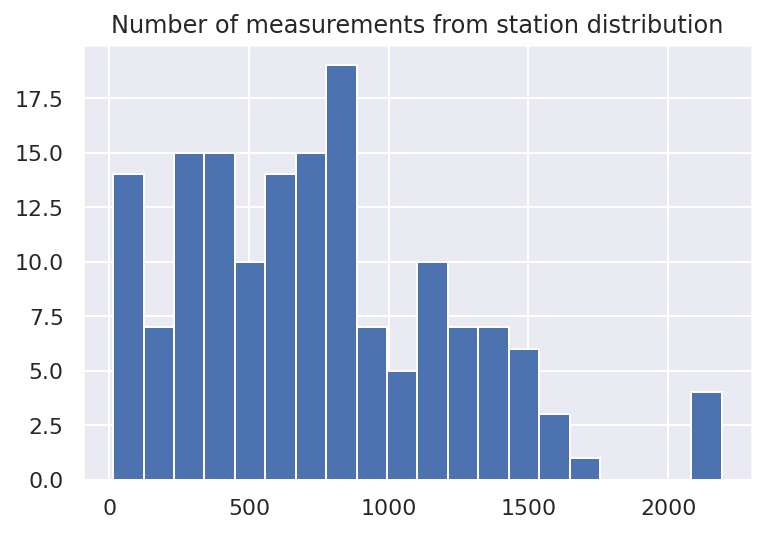

In [193]:
_, ax = plt.subplots()
df.groupby(level=0).count()["MaxTemp"].hist(bins=20, ax=ax)
ax.set_title("Number of measurements from station distribution")

Setting a specific date we can see how most of the station are in the northern empisphere, in a temperate climate

Text(0.5, 1.0, 'Distribution of temperature measurements in 1942-07-01')

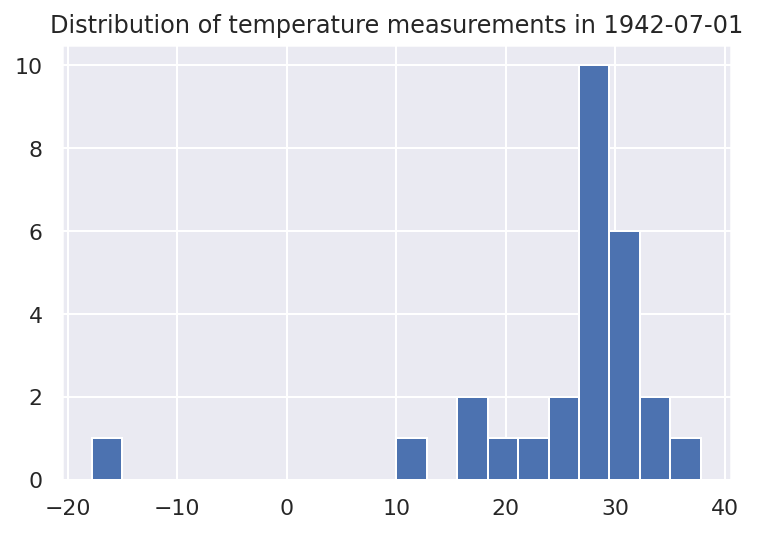

In [198]:
_, ax = plt.subplots()
df["MaxTemp"][:, pd.Timestamp("1942-07-01")].hist(bins=20, ax=ax)
ax.set_title("Distribution of temperature measurements in 1942-07-01")

### 2.3.3 Focus on sensor `22508`

<AxesSubplot:xlabel='Date'>

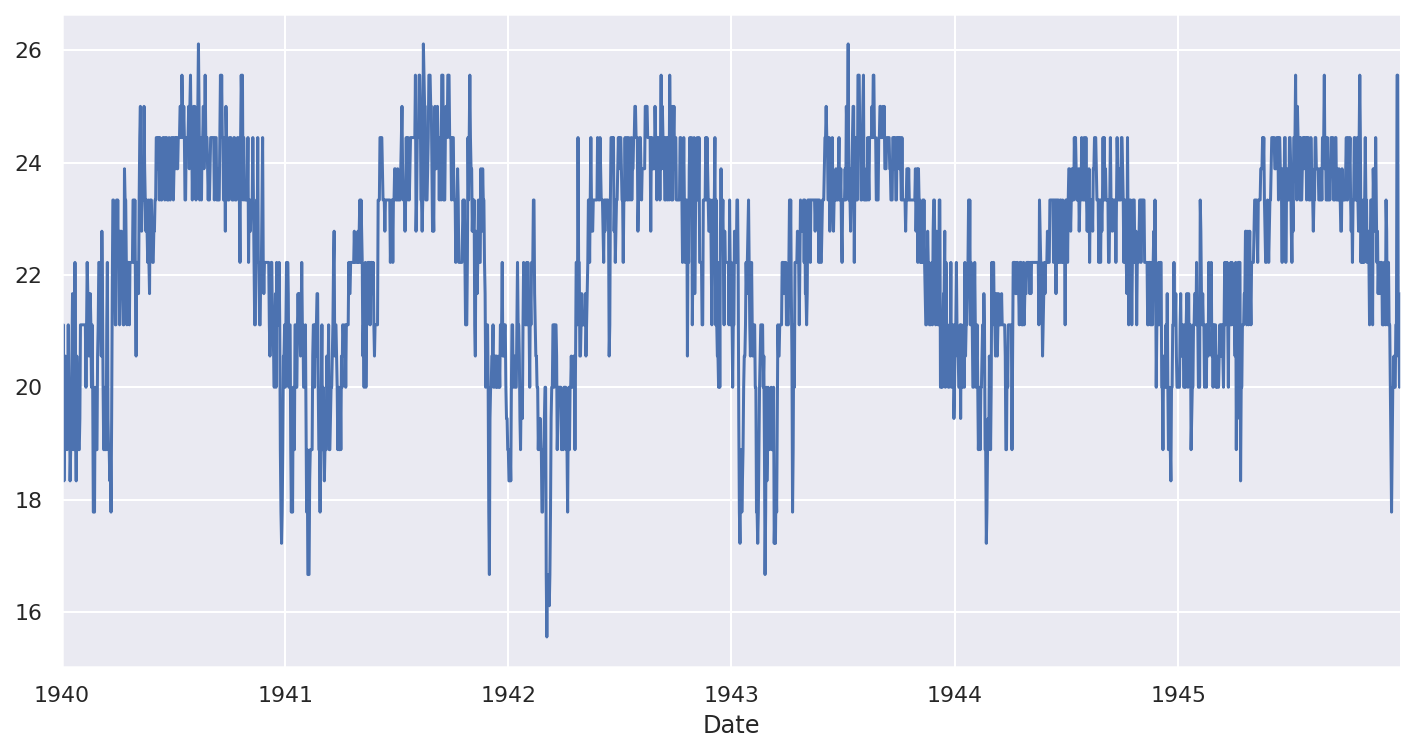

In [208]:
_, ax = plt.subplots(figsize=(12, 6))
df.loc[22508]["MeanTemp"].plot(ax=ax)

##### 2.3.3.1 Rolling window preprocessing

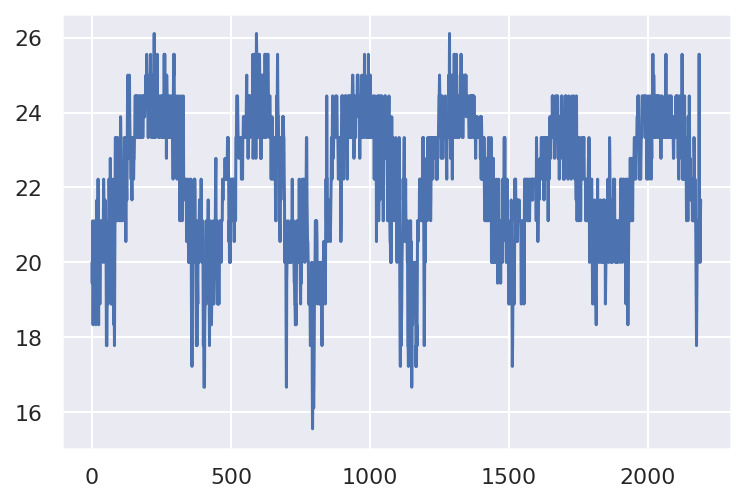

In [216]:
y = df.loc[22508]["MeanTemp"].to_numpy()
plt.plot(y)

In [309]:
def make_rolling_window(y, window_size):
    """
    Makes a matrix of shape = (y.size[0], window_size)
    where each row is a time and the columns are
    t-1, t-2, ... , t-window_size
    """
    n = y.shape[0]

    X = np.empty((n, window_size))

    for t in range(n):
        for s in range(window_size):
            X[t, s] = y[t - s - 1] if t - s > 0 else np.nan

    return X


window_size = 20
X = make_rolling_window(y, window_size)[window_size:, :]
y = y[window_size:]

assert np.sum(np.isnan(X)) == 0
assert np.sum(np.isnan(y)) == 0

X, y

(array([[21.11111111, 18.88888889, 18.88888889, ..., 18.88888889,
         18.88888889, 20.        ],
        [22.22222222, 21.11111111, 18.88888889, ..., 18.88888889,
         18.88888889, 18.88888889],
        [19.44444444, 22.22222222, 21.11111111, ..., 20.55555556,
         18.88888889, 18.88888889],
        ...,
        [21.11111111, 20.55555556, 25.55555556, ..., 22.22222222,
         22.22222222, 21.11111111],
        [20.        , 21.11111111, 20.55555556, ..., 21.11111111,
         22.22222222, 22.22222222],
        [21.11111111, 20.        , 21.11111111, ..., 21.11111111,
         21.11111111, 22.22222222]]),
 array([22.22222222, 19.44444444, 18.88888889, ..., 20.        ,
        21.11111111, 21.66666667]))

#### 2.3.3.2 Forecasting

##### 2.3.3.2.1 Linear Regression

In [333]:
from sklearn.model_selection import TimeSeriesSplit, cross_validate

{'fit_time': array([0.0020709 , 0.00482392, 0.01717687, 0.02861142, 0.00524473]),
 'score_time': array([0.00113034, 0.00126767, 0.00454593, 0.01117253, 0.00089502]),
 'estimator': (LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression()),
 'test_r2': array([0.80198035, 0.77791917, 0.78538183, 0.70724681, 0.67877048]),
 'test_neg_mean_squared_error': array([-0.65429422, -0.87733633, -0.70042957, -0.57910442, -0.7328037 ])}

Text(0.5, 1.0, 'Mean MSE: 0.709')

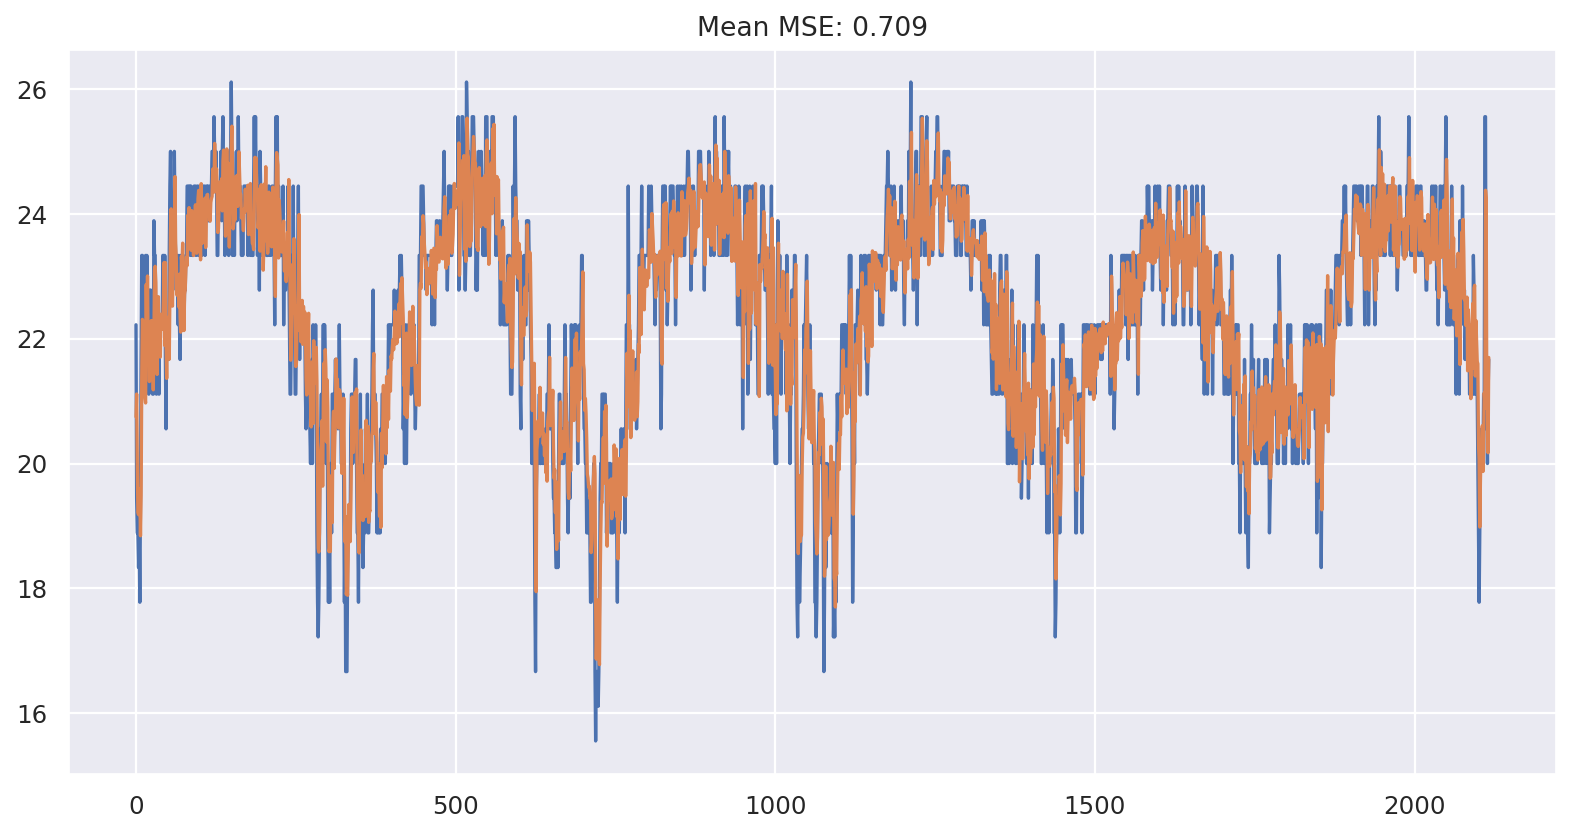

In [344]:
cv_results = cross_validate(
    LinearRegression(),
    X,
    y,
    cv=TimeSeriesSplit().split(X),
    scoring=["r2", "neg_mean_squared_error"],
    return_estimator=True,
)
display(cv_results)

_, ax = plt.subplots(figsize=(12, 6), dpi=80)
ax.plot(y)
ax.plot(cv_results["estimator"][0].predict(X))
ax.set_title(f"Mean MSE: {(-cv_results['test_neg_mean_squared_error'].mean()):.3f}")

##### 2.3.3.2.2 Random Forest

{'fit_time': array([0.24695778, 0.37377834, 0.53687787, 0.71068907, 0.85281515]),
 'score_time': array([0.01139545, 0.01225424, 0.01316714, 0.0141921 , 0.01438165]),
 'estimator': (RandomForestRegressor(),
  RandomForestRegressor(),
  RandomForestRegressor(),
  RandomForestRegressor(),
  RandomForestRegressor()),
 'test_r2': array([0.72715458, 0.76097854, 0.75745183, 0.68160476, 0.6670964 ]),
 'test_neg_mean_squared_error': array([-0.90153269, -0.94426075, -0.79158214, -0.62982779, -0.75943515])}

Text(0.5, 1.0, 'Mean MSE: 0.805')

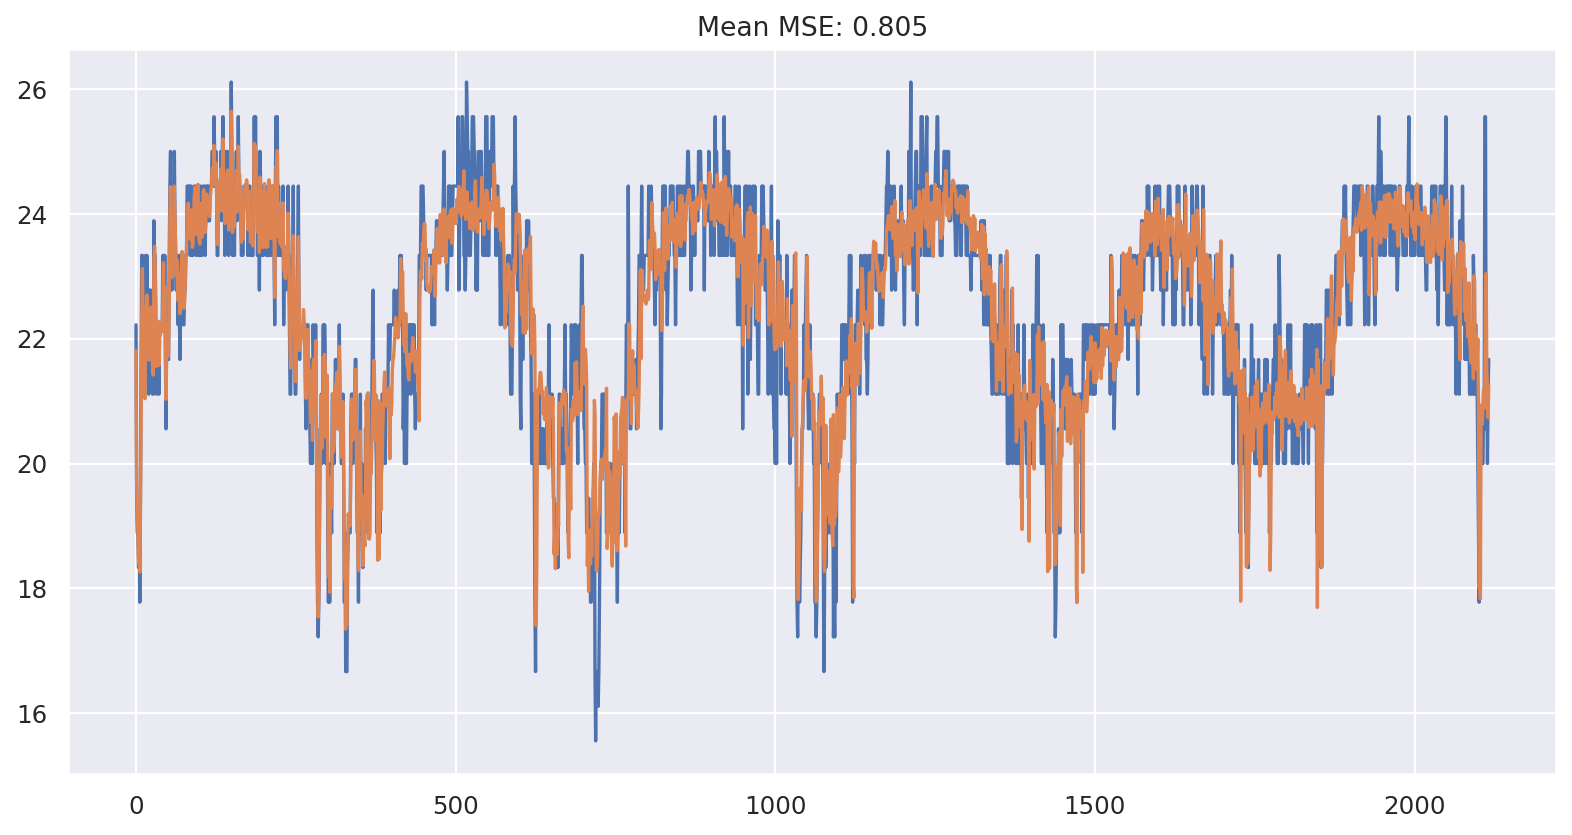

In [345]:
cv_results = cross_validate(
    RandomForestRegressor(),
    X,
    y,
    cv=TimeSeriesSplit().split(X),
    scoring=["r2", "neg_mean_squared_error"],
    return_estimator=True,
)
display(cv_results)

_, ax = plt.subplots(figsize=(12, 6), dpi=80)
ax.plot(y)
ax.plot(cv_results["estimator"][0].predict(X))
ax.set_title(f"Mean MSE: {(-cv_results['test_neg_mean_squared_error'].mean()):.3f}")

##### 2.3.3.2.3 Neural Network

{'fit_time': array([0.34165764, 0.83763671, 1.40822697, 1.61786008, 1.4908061 ]),
 'score_time': array([0.00134254, 0.00162935, 0.00131822, 0.00129175, 0.00129676]),
 'estimator': (MLPRegressor(hidden_layer_sizes=(50, 20), max_iter=15000),
  MLPRegressor(hidden_layer_sizes=(50, 20), max_iter=15000),
  MLPRegressor(hidden_layer_sizes=(50, 20), max_iter=15000),
  MLPRegressor(hidden_layer_sizes=(50, 20), max_iter=15000),
  MLPRegressor(hidden_layer_sizes=(50, 20), max_iter=15000)),
 'test_r2': array([0.71087625, 0.76597403, 0.76271946, 0.66074891, 0.65883798]),
 'test_neg_mean_squared_error': array([-0.95531936, -0.92452594, -0.77439066, -0.67108341, -0.77827462])}

Text(0.5, 1.0, 'Mean MSE: 0.821')

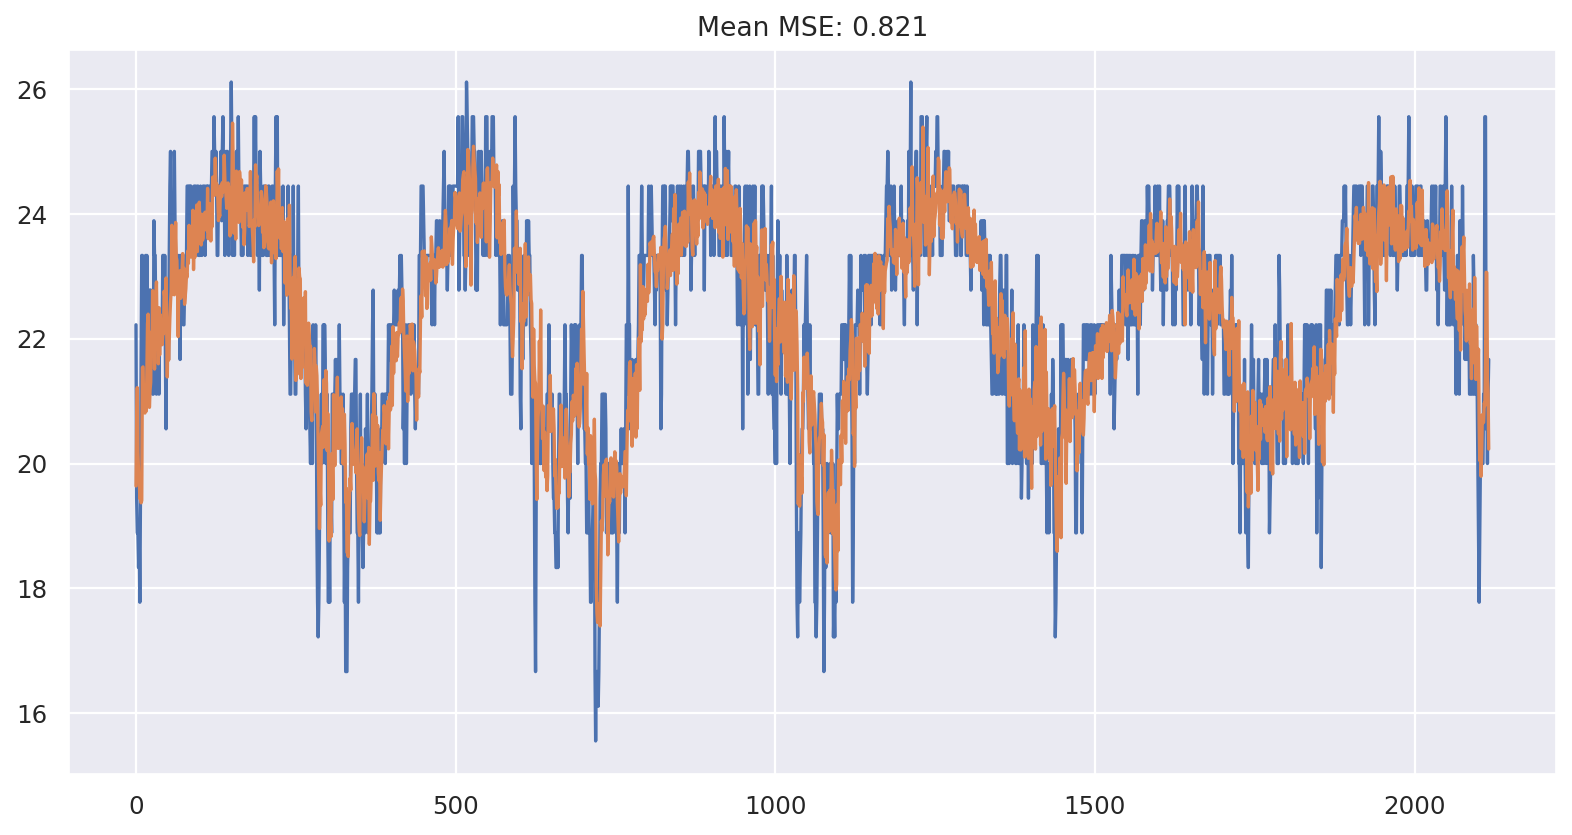

In [346]:
cv_results = cross_validate(
    MLPRegressor(hidden_layer_sizes=(50, 20), max_iter=15_000),
    X,
    y,
    cv=TimeSeriesSplit().split(X),
    scoring=["r2", "neg_mean_squared_error"],
    return_estimator=True,
)
display(cv_results)

_, ax = plt.subplots(figsize=(12, 6), dpi=80)
ax.plot(y)
ax.plot(cv_results["estimator"][0].predict(X))
ax.set_title(f"Mean MSE: {(-cv_results['test_neg_mean_squared_error'].mean()):.3f}")